In [1]:
# Notebook to put together plots and animations showing ocean model configuration
# Specifically to understand how the ocean state develops over time, how particualr metrics behave,
# and how the dynamics evolved as the model moves to equilibrium 

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from  matplotlib.animation import FFMpegWriter
import os
#import ffmpeg

from netCDF4 import Dataset
from matplotlib.cm import get_cmap
#from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
#                 cartopy_ylim, latlon_coords)

/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
# Read in the model data, both state files, and time averaged files

# currently running with small dummy file - same for both!

dir = '/data/oceans_output/open/racfur/4500yr_Windx0.50/'

inst_file = dir +'state.0000000000.t001.nc'
mm_file = dir+'state.0000000000.t001.nc'
#mon_file = dir+'monitor.0000000000.t001.nc '

ds_inst=xr.open_dataset(inst_file)
ds_mm=xr.open_dataset(mm_file)
#mon_file=xr.open_dataset(mon_file)

nc_inst = Dataset(inst_file)
nc_mm = Dataset(mm_file)
#nc_mon = Dataset(mon_file)

# Get the temperature fields
inst_Temp = nc_inst.variables['Temp'][:]
mm_Temp = nc_mm.variables['Temp'][:]

#close the files
nc_inst.close()
nc_mm.close()

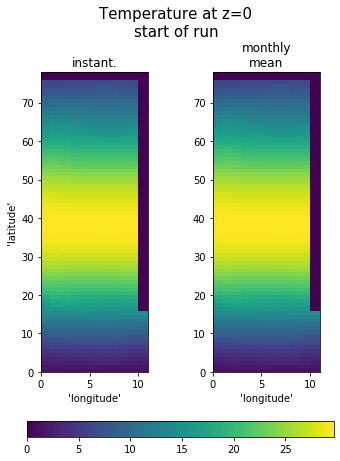

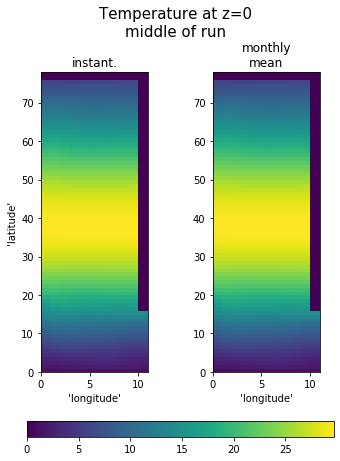

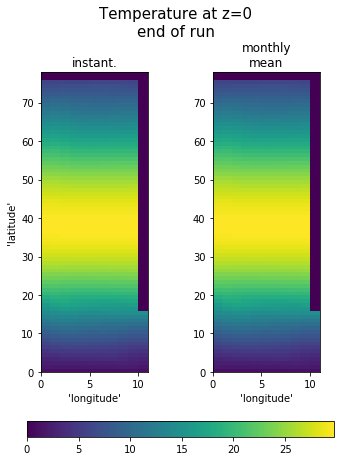

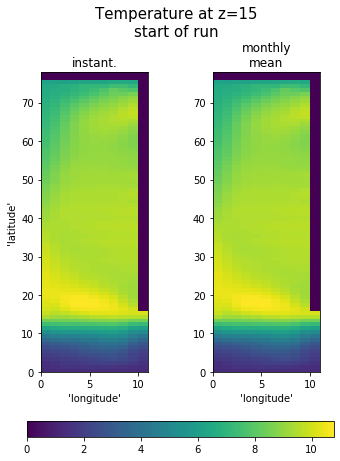

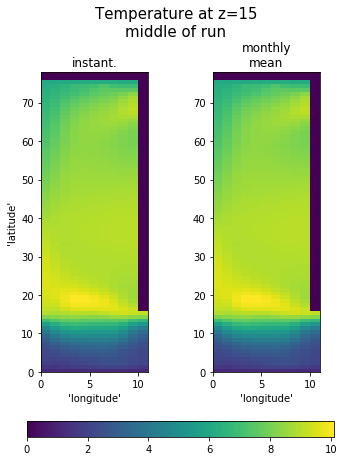

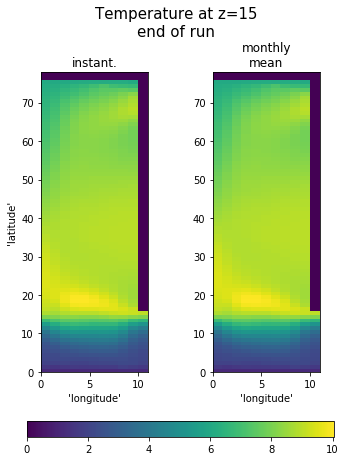

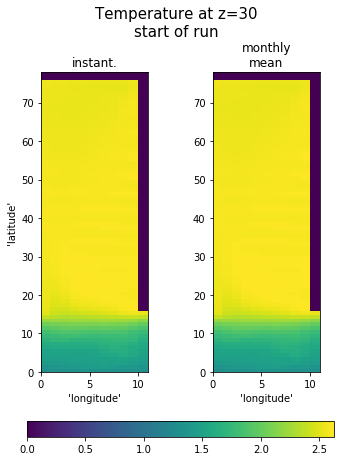

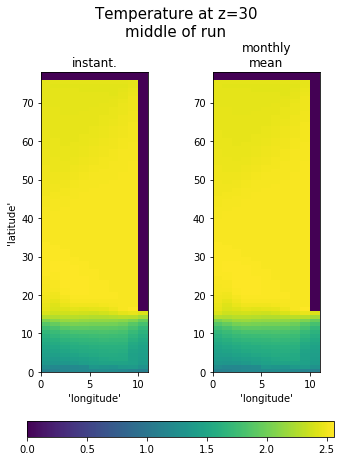

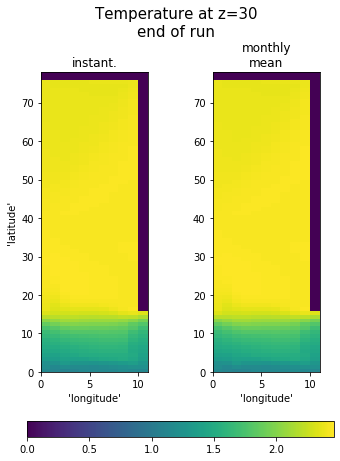

In [3]:
# Plot temperature fields at a few discrete times - start, middle and end, 
# from both monthly mean files and instantaneous files
# for the surface and a mid-depth

start = [15, 'start']
mid = [round(ds_mm.T.size/2), 'middle']
end = [ds_mm.T.size - 1, 'end']

for depth in [0,15,30]:
    for time in [start, mid, end]:
        # Create a figures of surface Temp
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(5,7))
        im1 = ax1.pcolormesh((inst_Temp[time[0],depth,:,:]))
        ax1.set_title('instant.')
        im2 = ax2.pcolormesh((mm_Temp[time[0],depth,:,:]))
        ax2.set_title('monthly\nmean')
    
        plt.subplots_adjust(wspace=.6, top=0.85, bottom=0.0)
        ax1.set_xlabel('\'longitude\'')
        ax2.set_xlabel('\'longitude\'')
        ax1.set_ylabel('\'latitude\'')
        plt.suptitle('Temperature at z='+str(depth)+'\n'+time[1]+' of run', x=0.5, y=0.98, fontsize=15)

        # Add a color bar
        #cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.1, pad=0.1)
        cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.1, anchor=(0.5, 1.3))
        
        plt.show()
        fig.savefig('../model_plots_anims/Temp_'+time[1]+'_z'+str(depth)+'.png')
        plt.close()


In [4]:
# Make animation of surface field over time for monthly mean file, and instantaneous output file
# Following method from http://tech.weatherforce.org/blog/ecmwf-data-animation/index.html, 
# see also https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

plt.rcParams['animation.ffmpeg_path'] = '/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/bin/ffmpeg'

for depth in [0,15,30]:

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(5,7))

    frames = 20 #  inst_Temp[:,0,0,0].shape[0]      # Number of frames
    min_value = np.floor(min(np.amin(inst_Temp[:,depth,:,:]), np.amin(mm_Temp[:,depth,:,:])))  # Lowest value
    max_value = np.ceil(max(np.amax(inst_Temp[:,depth,:,:]), np.amax(mm_Temp[:,depth,:,:])))   # Highest value
    print(min_value, max_value)

    def draw(frame, add_colorbar):
        ax1=axes[0]
        ax2=axes[1]
        im1 = ax1.pcolormesh(inst_Temp[frame,depth,:,:], vmin=min_value, vmax=max_value)
        ax1.set_title('instant.')
        im2 = ax2.pcolormesh(mm_Temp[frame,depth,:,:], vmin=min_value, vmax=max_value) 
        ax2.set_title('monthly\nmean')

        plt.subplots_adjust(wspace=.6, top=0.85, bottom=0.0)
        ax1.set_xlabel('\'longitude\'')
        ax2.set_xlabel('\'longitude\'')
        ax1.set_ylabel('\'latitude\'')
        plt.suptitle('Temperature at z='+str(depth)+'\ntime = '+str(frame), x=0.5, y=0.98, fontsize=15)            

        ## Add a color bar
        if add_colorbar:
            cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.1, anchor=(0.5, 1.))

        plt.close()    
        return im1
       
    def init():
        return draw(0, add_colorbar=True)

    def animate(frame):
        return draw(frame, add_colorbar=False)

    ani = animation.FuncAnimation(fig, animate, frames, interval=20, blit=False,
                                  init_func=init, repeat=False)
    ani.save('../model_plots_anims/temp_z'+str(depth)+'.mp4', writer=animation.FFMpegWriter(fps=8))
    plt.show()
    plt.close(fig)

0.0 30.0
0.0 12.0
0.0 3.0


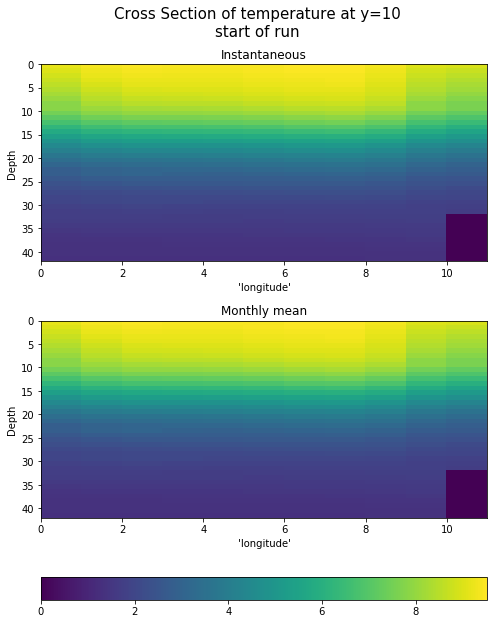

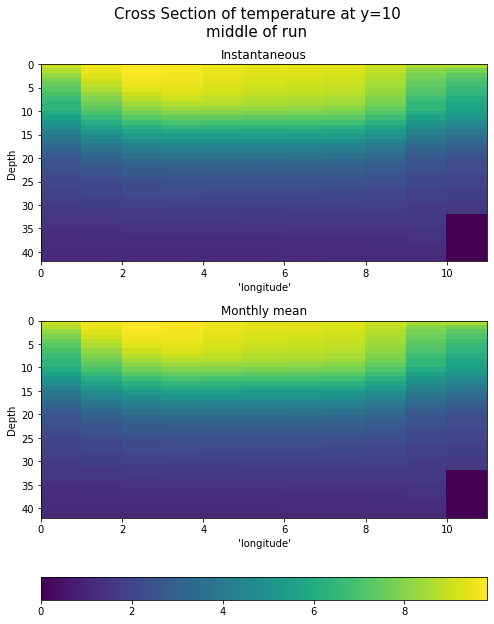

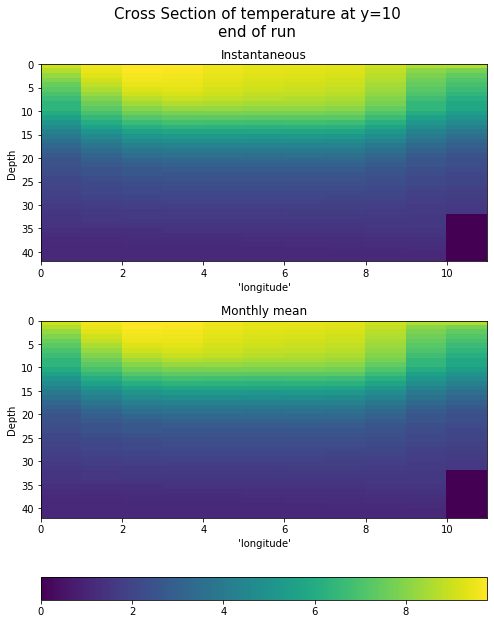

In [5]:
# Plot cross sections for y=const at a few discrete time points - start, middle and end, 
# from both monthly mean files and instantaneous files

# start, middle and end points defined above
y=10

# Plot cross section at y=const (i.e. east to west)
for time in [start, mid, end]:
    # Create a figures of surface Temp
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(8,10))
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    im1 = ax1.pcolormesh(inst_Temp[time[0],:,y,:])
    ax1.set_title('Instantaneous')
    im2 = ax2.pcolormesh(mm_Temp[time[0],:,y,:])
    ax2.set_title('Monthly mean')

    #fig.text(0.5, 0.155, 'latitude', ha='center', va='center', fontsize=11)
    ax1.set_ylabel('Depth')
    ax2.set_ylabel('Depth')
    ax1.set_xlabel('\'longitude\'')
    ax2.set_xlabel('\'longitude\'')
    plt.suptitle('Cross Section of temperature at y='+str(y)+'\n'+time[1]+' of run', x=0.5, y=0.98, fontsize=15)

    plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.0)

    # Add a color bar
    cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.0, anchor=(0.5, 1.5))

    plt.show()
    fig.savefig('../model_plots_anims/CrossSection_temp_y'+str(y)+'_'+time[1]+'.png')
    plt.close()


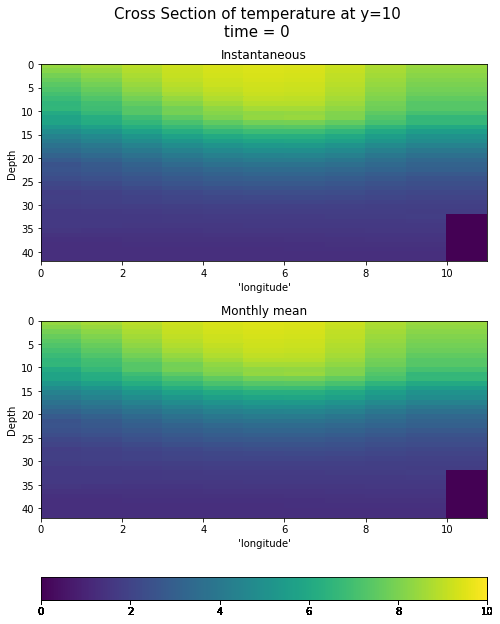

In [11]:
# Make animation of cross section  at y=const, in the Southern Ocean over time - Monthly means and instantaneous outputs
# Following method from http://tech.weatherforce.org/blog/ecmwf-data-animation/index.html, 
# see also https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

plt.rcParams['animation.ffmpeg_path'] = '/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/bin/ffmpeg'

y=10

# Plot cross section at y=const (i.e. east to west)
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(8,10))
axes[0].invert_yaxis()
axes[1].invert_yaxis()

frames = 20 #  inst_Temp[:,0,0,0].shape[0]      # Number of frames
min_value = np.floor(min(np.amin(inst_Temp[:,:,y,:]), np.amin(mm_Temp[:,:,y,:])))  # Lowest value
max_value = np.ceil(max(np.amax(inst_Temp[:,:,y,:]), np.amax(mm_Temp[:,:,y,:])))   # Highest value

def draw(frame, add_colorbar):
    ax1=axes[0]
    ax2=axes[1]    
    im1 = ax1.pcolormesh(inst_Temp[frame,:,y,:], vmin=min_value, vmax=max_value)
    ax1.set_title('Instantaneous')
    im2 = ax2.pcolormesh(mm_Temp[frame,:,y,:], vmin=min_value, vmax=max_value) 
    ax2.set_title('Monthly mean')##

    ##plt.ylabel
    ax1.set_ylabel('Depth')
    ax2.set_ylabel('Depth')
    ax1.set_xlabel('\'longitude\'')
    ax2.set_xlabel('\'longitude\'')
    plt.suptitle('Cross Section of temperature at y='+str(y)+'\ntime = '+str(frame), x=0.5, y=0.98, fontsize=15)

    plt.subplots_adjust(hspace=0.3, top=0.9, bottom=0.0)

    # Add a color bar
    if add_colorbar:
        cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=1.0, anchor=(0.5, 1.5))

    return im1
   
def init():
    return draw(0, add_colorbar=True)

def animate(frame):
    return draw(frame, add_colorbar=True)

ani = animation.FuncAnimation(fig, animate, frames, interval=20, blit=False,
                              init_func=init, repeat=False)
ani.save('../model_plots_anims/CrossSection_temp_y'+str(y)+'.mp4', writer=animation.FFMpegWriter(fps=8))
plt.show()
plt.close(fig)


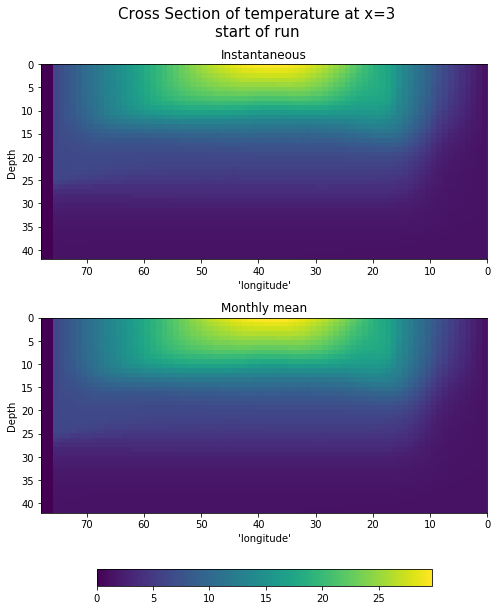

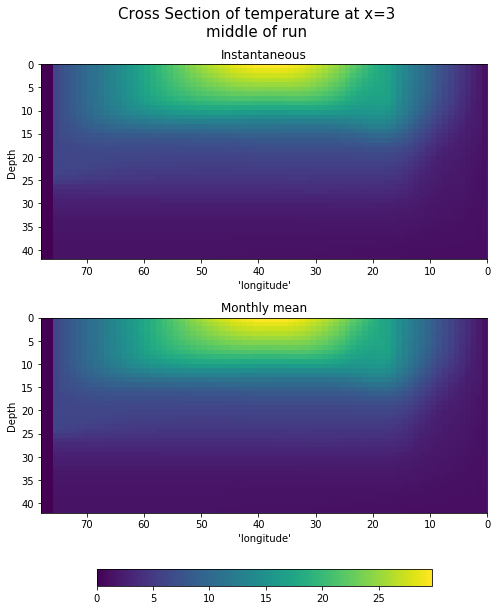

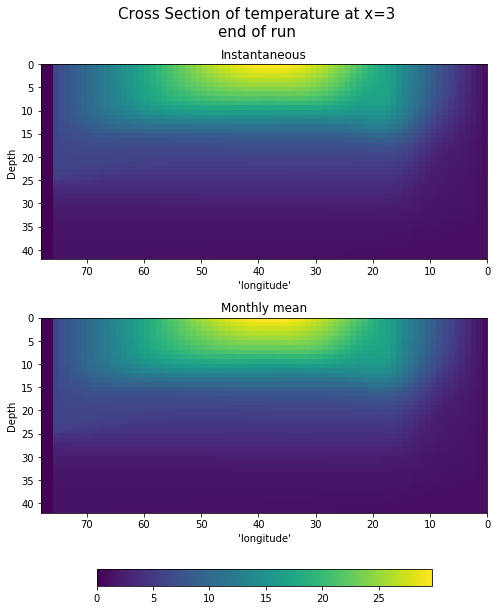

In [7]:
# Plot cross section at x=const (i.e. North to South)    

x=3

for time in [start, mid, end]:
    # Create a figures of surface Temp
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(8,10))
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax1.invert_xaxis()
    ax2.invert_xaxis()  
    im1 = ax1.pcolormesh(inst_Temp[time[0],:,:,x])
    ax1.set_title('Instantaneous')
    im2 = ax2.pcolormesh(mm_Temp[time[0],:,:,x])
    ax2.set_title('Monthly mean')

    ax1.set_ylabel('Depth')
    ax2.set_ylabel('Depth')
    ax1.set_xlabel('\'longitude\'')
    ax2.set_xlabel('\'longitude\'')
    plt.suptitle('Cross Section of temperature at x='+str(x)+'\n'+time[1]+' of run', x=0.5, y=0.97, fontsize=15)

    plt.subplots_adjust(hspace=0.3, top=0.89, bottom=0.0)

    # Add a coy=10lor bar
    cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=0.75, anchor=(0.5, 1.5))
    
    plt.show()
    fig.savefig('../model_plots_anims/CrossSection_temp_x'+str(x)+'_'+time[1]+'.png')
    plt.close() 

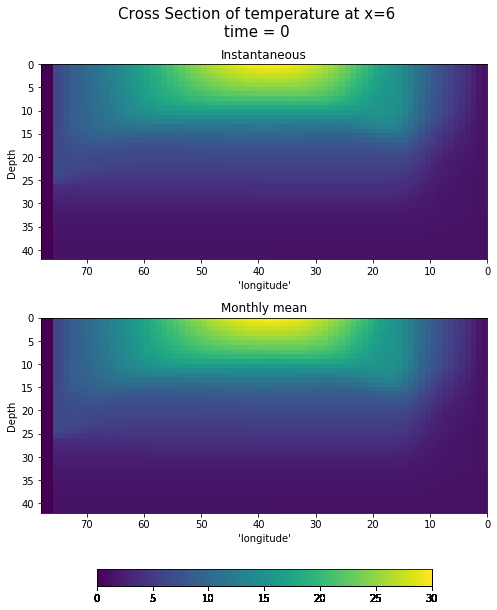

In [8]:
# Make animation of cross section  at x=const, over time - Monthly means and instantaneous outputs
# Following method from http://tech.weatherforce.org/blog/ecmwf-data-animation/index.html, 
# see also https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

plt.rcParams['animation.ffmpeg_path'] = '/data/hpcdata/users/racfur/conda-envs/RF_hpc_clean/bin/ffmpeg'

x=6

# Plot cross section at y=const (i.e. east to west)
fig, axes = plt.subplots(nrows=2, ncols=1, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(8,10))
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].invert_xaxis()
axes[1].invert_xaxis()
    
frames = 20 #  inst_Temp[:,0,0,0].shape[0]      # Number of frames
min_value = np.floor(min(np.amin(inst_Temp[:,:,:,x]), np.amin(mm_Temp[:,:,:,x])))  # Lowest value
max_value = np.ceil(max(np.amax(inst_Temp[:,:,:,x]), np.amax(mm_Temp[:,:,:,x])))   # Highest value

def draw(frame, add_colorbar):
    ax1=axes[0]
    ax2=axes[1]
    im1 = ax1.pcolormesh(inst_Temp[frame,:,:,x], vmin=min_value, vmax=max_value)
    ax1.set_title('Instantaneous')
    im2 = ax2.pcolormesh(mm_Temp[frame,:,:,x], vmin=min_value, vmax=max_value) 
    ax2.set_title('Monthly mean')##

    ax1.set_ylabel('Depth')
    ax2.set_ylabel('Depth')
    ax1.set_xlabel('\'longitude\'')
    ax2.set_xlabel('\'longitude\'')
    plt.suptitle('Cross Section of temperature at x='+str(x)+'\ntime = '+str(frame), x=0.5, y=0.97, fontsize=15)
    plt.subplots_adjust(hspace=0.3, top=0.89, bottom=0.0)
    
    # Add a color bar
    if add_colorbar:
        cb=plt.colorbar(im1, ax=(ax1,ax2), location='bottom', shrink=0.75, anchor=(0.5, 1.5))

    return im1
   
def init():
    return draw(0, add_colorbar=True)

def animate(frame):
    return draw(frame, add_colorbar=True)

ani = animation.FuncAnimation(fig, animate, frames, interval=20, blit=False,
                              init_func=init, repeat=False)
ani.save('../model_plots_anims/CrossSection_temp_x'+str(x)+'.mp4', writer=animation.FFMpegWriter(fps=8))
plt.show()
plt.close(fig)

[1, 1, 0]


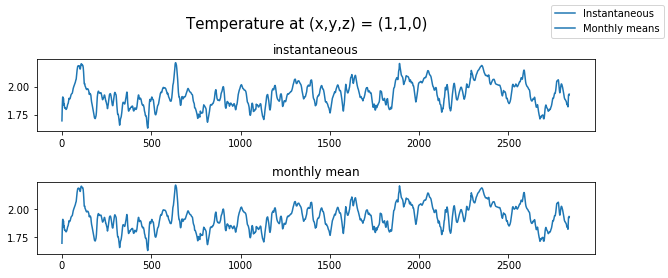

In [9]:
# Plot time series at a few specific points, with monthly mean and instantaneous on same plot

points=[[1,1,0]]   # list of x,y,z points

for point in points:
    print(point)
    # Create a time series of temp from mm and inst files
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=True, squeeze=True, subplot_kw=None, gridspec_kw=None, figsize=(10,4))
    im1 = ax1.plot(inst_Temp[:,point[2],point[1],point[0]],label=('Instantaneous'))
    ax1.set_title('instantaneous')
    im2 = ax2.plot(mm_Temp[:,point[2],point[1],point[0]],label=('Monthly means'))
    ax2.set_title('monthly mean')
    plt.suptitle('Temperature at (x,y,z) = ('+str(point[0])+','+str(point[1])+','+str(point[2])+')', x=0.5, y=0.95, fontsize=15)
    plt.subplots_adjust(hspace=0.7, top=0.8)
    fig.legend()
    
    plt.show()
    fig.savefig('../model_plots_anims/Temp_x'+str(point[0])+'_y'+str(point[1])+'_z'+str(point[2])+'.png')
    plt.close()

In [10]:
# Calculate some specific metrics (WHAT?!) and output these/plot time series of these metrics over time

nc_mon.variables['Theta_min']

fig = plt_figure()
fig.plot(nc_mon.variables['Theta_min'])
fig.set_title('Minimum Temperature')


NameError: name 'nc_mon' is not defined